# Lab 8 - BCC406

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## *Word Embedding*

### Prof. Eduardo e Prof. Pedro

Objetivos:

- Parte I : Uso de BoW para PLN

- Parte II : Comparação com *word embedding* simples

- Parte III: Visualizando as representações das palavras no espaço


Data da entrega : 11/03

- Complete o código (marcado com ToDo) e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Execute todo notebook e salve tudo em um PDF **nomeado** como "NomeSobrenome-Lab.pdf"
- Envie o PDF via google [FORM](https://forms.gle/gm1egpnfvTdQXYwp7)

Este notebook é baseado em tensorflow e Keras.

# Representações de texto (*Bag-of-Words* vs. *Word Embeddings*) em NLP

Neste exercício prático, vamos explorar duas abordagens diferentes para representar textos em português e treinar um modelo de classificação de texto simples. Usaremos um dataset desafiador de NLP em português – por exemplo, **[resenhas de filmes](https://https://drive.google.com/file/d/1KVIxGF6AVD6i43JPT0DBIZzYKJrBMoE5/view?usp=drive_link)** traduzidas para PT-BR, rotuladas como _positivas_ ou _negativas_.  O [dataset](https://https://drive.google.com/file/d/1KVIxGF6AVD6i43JPT0DBIZzYKJrBMoE5/view?usp=drive_link) contempla o review dado pelos usuários e o sentimento daquele review (positivo/negativo) com relação ao filme. O objetivo é, dado um review (ou resenha) em portugues, classificar o texto como positivo ou negativo.

O exercício será dividido em duas etapas principais:  

1. **Bag-of-Words + MLP:** Transformar os textos em vetores numéricos usando a técnica de **Bag-of-Words** (saco de palavras) baseada em frequência, e então treinar uma rede neural simples do tipo MLP (Perceptron Multicamadas) para classificar as resenhas.  
2. **Word Embeddings + MLP:** Utilizar uma camada de **embedding** para converter palavras em vetores densos de dimensões menores, e treinar o mesmo modelo MLP, comparando os resultados com a abordagem de Bag-of-Words.  

## Importando as bibliotecas


Aqui, faremos a importação de todas as bibliotecas que serão usadas nesta prática.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, BatchNormalization
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

## Preparando os dados


Aqui assumiremos um dataset de **resenhas de filmes em português**, já categorizadas como sendo de sentimento **positivo** ou **negativo**.

O dataset está disponível em um arquivo CSV, [na pasta da prática](https://https://drive.google.com/file/d/1KVIxGF6AVD6i43JPT0DBIZzYKJrBMoE5/view?usp=drive_link). Os passos a seguir demonstram como carregar e inspecionar os dados.

O primeiro passo é fazer o download do arquivo.


In [2]:
!gdown 1KVIxGF6AVD6i43JPT0DBIZzYKJrBMoE5

Downloading...
From (original): https://drive.google.com/uc?id=1KVIxGF6AVD6i43JPT0DBIZzYKJrBMoE5
From (redirected): https://drive.google.com/uc?id=1KVIxGF6AVD6i43JPT0DBIZzYKJrBMoE5&confirm=t&uuid=0595ac30-90fb-4e57-8b33-999aae39deaa
To: /content/imdb-reviews-pt-br.csv
100% 127M/127M [00:02<00:00, 55.9MB/s]


Fazer a leitura do arquivo das resenhas com o pacote Pandas.

In [2]:
df = pd.read_csv('imdb-reviews-pt-br.csv')

Inspecionando os dados.

In [4]:
# Verificar as primeiras linhas do dataset para entender sua estrutura
print(f"Número de exemplos: {len(df)}")
print(df.head(5))

Número de exemplos: 49459
   id                                            text_en  \
0   1  Once again Mr. Costner has dragged out a movie...   
1   2  This is an example of why the majority of acti...   
2   3  First of all I hate those moronic rappers, who...   
3   4  Not even the Beatles could write songs everyon...   
4   5  Brass pictures movies is not a fitting word fo...   

                                             text_pt sentiment  
0  Mais uma vez, o Sr. Costner arrumou um filme p...       neg  
1  Este é um exemplo do motivo pelo qual a maiori...       neg  
2  Primeiro de tudo eu odeio esses raps imbecis, ...       neg  
3  Nem mesmo os Beatles puderam escrever músicas ...       neg  
4  Filmes de fotos de latão não é uma palavra apr...       neg  


**Explicação:** O código acima lê o arquivo CSV contendo as resenhas. Substitua `'imdb-reviews-pt-br.csv'` pelo caminho adequado do seu dataset. Usamos `df.head(5)` para ver as primeiras 5 entradas e inspecionar as colunas. Provavelmente, o dataset terá uma coluna para o texto da resenha (por exemplo, `review_pt` ou `texto`) e outra para o rótulo de sentimento (por exemplo, `sentiment` indicando *positivo/negativo*).  

O próximo passo é  extrair as colunas de texto e rótulo para listas (ou arrays) separados, o que facilitará o manuseio posteriormente.

In [3]:
texts = df['text_pt'].astype(str).values    # convertendo para string por segurança
labels = df['sentiment'].map({'neg': 0, 'pos': 1}).values

Fazendo uma análise do que foi carregado.

In [6]:
print("Total de textos:", len(texts))
print("Exemplo de texto:", texts[0][:100], "...")  # imprime começo do primeiro texto
print("Rótulo desse texto:", labels[0])

Total de textos: 49459
Exemplo de texto: Mais uma vez, o Sr. Costner arrumou um filme por muito mais tempo do que o necessário. Além das terr ...
Rótulo desse texto: 0


**Nota:** Caso seu dataset tenha rótulos como "positivo"/"negativo" ou "pos"/"neg", converta-os para valores numéricos (e.g., 1 para positivo, 0 para negativo) conforme mostrado no comentário acima, pois isso facilita o treinamento do modelo.  

Para simplificar o exercício e reduzir tempo de processamento (deixando-o _leve_), podemos **opcionalmente** trabalhar com uma amostra menor do dataset. Por exemplo, usar apenas 10.000 exemplos se o conjunto completo for muito grande.

In [7]:
# OPCIONAL: usar somente uma parte dos dados para treinamento mais rápido (por exemplo, 10000 primeiras linhas)
df = df.sample(10000, random_state=42)  # amostra aleatória de 10000 exemplos

Agora que os dados estão carregados e prontos, vamos iniciar a **Parte 1: Bag-of-Words + MLP**.

## Bag-of-Words + MLP

Nesta parte, vamos converter cada texto em uma representação numérica usando a técnica de **Bag-of-Words (BoW)** e depois treinar um modelo de rede neural simples para classificar os textos.  

### O que é Bag-of-Words?  

Bag-of-Words é uma das representações mais simples para texto. Nesta abordagem:  

- **Vocabulário:** Primeiro definimos um vocabulário de palavras a partir do conjunto de textos de treino. O vocabulário pode ser todas as palavras distintas presentes ou um subconjunto (por exemplo, as N palavras mais frequentes).  
- **Vetores de Frequência:** Cada texto é representado por um vetor de comprimento igual ao tamanho do vocabulário. Em cada posição do vetor colocamos a **frequência** (contagem) de ocorrência da palavra correspondente naquele texto. Por exemplo, se a palavra `filme` é a 5ª palavra do vocabulário, o elemento índice 5 do vetor conterá quantas vezes `filme` aparece na resenha.  
- Por essa razão, é chamado de "saco de palavras": a ordem das palavras é **ignorada**. Apenas importa quantas vezes cada palavra apareceu. Em outras palavras, um documento é representado como um **multiconjunto** de palavras.  

**Exemplo simples:**  
Considere dois textos:  
- Texto A: "gostei do filme filme excelente"  
- Texto B: "não gostei do filme"  

Suponha que o vocabulário construído seja: `[gostei, do, filme, excelente, não]`.  
- Texto A teria representação BoW = `[1, 1, 2, 1, 0]` (1 ocorrência de "gostei", 1 de "do", 2 de "filme", 1 de "excelente", 0 de "não").  
- Texto B teria representação BoW = `[1, 1, 1, 0, 1]` (1 "gostei", 1 "do", 1 "filme", 0 "excelente", 1 "não").  

Observe que a posição de cada número corresponde a uma palavra do vocabulário.  

### Limitações do Bag-of-Words  

Embora seja fácil de entender e implementar, a representação Bag-of-Words tem algumas limitações importantes:  

- **Alta Dimensionalidade:** O vetor resultante tem dimensão igual ao tamanho do vocabulário, que pode ser muito grande (milhares ou dezenas de milhares de palavras). Isso pode causar **esparsidade**, já que cada texto individual usa apenas uma fração do vocabulário (muitos zeros no vetor), exigindo mais memória e podendo dificultar o aprendizado do modelo.  
- **Sem ordem ou contexto:** Como a ordem das palavras é ignorada, informações contextuais importantes se perdem. Por exemplo, "não, gostei" e "gostei não" teriam a mesma contagem de palavras, apesar de o significado ser diferente por causa da ordem. Bag-of-words não captura estruturas sintáticas ou a proximidade entre palavras.  
- **Não captura o significado ou similaridade das palavras:** Cada palavra é uma dimensão independente. Palavras como **"ótimo"** e **"excelente"** serão representadas em dimensões diferentes, mesmo tendo significado semelhante. O modelo precisaria aprender do zero que ambas indicam algo positivo, pois BoW não fornece nenhuma noção de que essas palavras estão relacionadas. Em resumo, BoW trata palavras como tokens independentes sem nenhuma relação intrínseca.  

Apesar dessas limitações, Bag-of-Words costuma funcionar bem em tarefas simples e é um bom ponto de partida para entendermos representações de texto.  


### Implementação Bag-of-Words + MLP

Agora vamos colocar em prática: primeiro transformando nossos textos em vetores de frequência (BoW), depois treinando um modelo de classificação simples.  



#### **1. Vetorização com Bag-of-Words:**  



Usaremos a biblioteca **scikit-learn** ou utilitários do Keras para converter a lista de textos em uma matriz de características. Uma forma prática é usar `CountVectorizer` do scikit-learn, que faz todo o processo de: tokenizar os textos, construir o vocabulário e contar frequências.  

Vamos limitar o tamanho do vocabulário para, digamos, as 5000 palavras mais frequentes, a fim de tornar a representação mais leve (ignorando palavras muito raras, que pouco contribuem e só aumentam a dimensão).  

In [18]:
max_features = 5000  # tamanho máximo do vocabulário
vectorizer = CountVectorizer(max_features=max_features, stop_words=None)  # podemos adicionar stop_words='portuguese' se quisermos remover stopwords

Com os parâmetros definidos, é possível treinar o vetorizaor nos textos de treino e transformar os textos em matriz BoW, onde a matriz resultante será esparsa e com dimensão `(n_amostras, max_features)`

In [19]:
X_bow = vectorizer.fit_transform(texts)

print("Formato da matriz BoW:", X_bow.shape)

Formato da matriz BoW: (49459, 5000)


Após essa etapa, `X_bow` é uma matriz esparsa onde cada linha corresponde a um texto, e cada coluna a uma palavra do vocabulário (de tamanho até 5000). O valor em `X_bow[i,j]` é a contagem da j-ésima palavra do vocabulário no i-ésimo texto.  

Podemos inspecionar alguns exemplos para ter certeza de que faz sentido:  

In [20]:
# Ver algumas palavras do vocabulário
print("Algumas palavras do vocabulário:", vectorizer.get_feature_names_out()[:100])

# Mostrar vetor BoW da primeira resenha (convertido para array denso apenas para visualizar)
print("Vetor BoW da primeira resenha:\n", X_bow[0].toarray())

# (Nota: a maioria dos elementos será zero; podemos também somar para ver o total de palavras contadas)
print("Total de palavras na primeira resenha:", int(X_bow[0].sum()))

Algumas palavras do vocabulário: ['00' '000' '10' '100' '11' '12' '13' '14' '15' '16' '17' '18' '19' '1930'
 '1940' '1950' '1960' '1970' '1972' '1979' '1980' '1990' '1995' '1996'
 '1999' '20' '2000' '2001' '2002' '2003' '2004' '2005' '2006' '2007' '21'
 '24' '25' '30' '35' '40' '45' '50' '60' '70' '80' '90' '99' 'abaixo'
 'abandonado' 'abc' 'aberta' 'aberto' 'abertura' 'abordagem' 'aborrecido'
 'abre' 'abrir' 'absoluta' 'absolutamente' 'absoluto' 'absurda' 'absurdo'
 'abundância' 'abuso' 'acaba' 'acabado' 'acabam' 'acabar' 'acabaram'
 'acabei' 'acabou' 'academia' 'acampamento' 'acaso' 'aceita' 'aceitar'
 'aceitável' 'acha' 'acham' 'achar' 'achava' 'achei' 'acho' 'achou'
 'acidentalmente' 'acidente' 'acima' 'acompanha' 'acompanhar' 'acontece'
 'acontecem' 'acontecendo' 'acontecer' 'aconteceu' 'acontecido'
 'acontecimentos' 'aconteça' 'acorda' 'acordado' 'acordo']
Vetor BoW da primeira resenha:
 [[0 0 0 ... 1 0 0]]
Total de palavras na primeira resenha: 132


#### **2. Dividir dados em treino e teste:**  

Antes de treinar o modelo, é importante separar uma parte dos dados para teste (avaliação). Assim podemos medir o desempenho em dados não vistos durante o treino. Vamos dividir, por exemplo, 80% para treino e 20% para teste.  

In [21]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    X_bow, labels, test_size=0.2, random_state=42)

print("Conjunto de treino - textos:", X_train_bow.shape, " rótulos:", y_train.shape)
print("Conjunto de teste - textos:", X_test_bow.shape, " rótulos:", y_test.shape)

Conjunto de treino - textos: (39567, 5000)  rótulos: (39567,)
Conjunto de teste - textos: (9892, 5000)  rótulos: (9892,)


#### **3. Definir e treinar o modelo MLP:**

Usaremos uma rede neural simples (MLP) para classificação binária (positivo/negativo). Como entrada, o MLP receberá os vetores BoW de cada texto. Nossa arquitetura será simples para ser rápida de treinar: por exemplo, uma camada densa escondida com algumas unidades e ReLU, seguida de uma camada de saída com ativação sigmoide (para prever a probabilidade de classe positiva).  

Detalhes:  
- Input dimension = tamanho do vocabulário (5000 características neste caso).  
- Uma camada oculta, digamos com 16 ou 32 neurônios, ativação ReLU. (Poderia ser mais complexa, mas manteremos simples).  
- Saída: 1 neurônio com ativação sigmoide (porque é binário).  
- Função de perda: `binary_crossentropy` (entropia cruzada binária).  
- Otimizador: por exemplo, `adam`.  
- Métrica: acurácia (para acompanhar desempenho).  

Vamos construir o modelo usando Keras (TensorFlow):  

In [22]:
# Construir modelo MLP para Bag-of-Words
model_bow = Sequential()
model_bow.add(Dense(16, activation='relu', input_shape=(X_train_bow.shape[1],)))
model_bow.add(Dense(1, activation='sigmoid'))  # saída binária

model_bow.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_bow.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 16)                  │          80,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,033 (312.63 KB)

 Trainable params: 80,033 (312.63 KB)

 Non-trainable params: 0 (0.00 B)

**Observação:** A camada de entrada (`Dense(16, ..., input_shape=(X_train_bow.shape[1],))`) espera um vetor de tamanho 5000 (no nosso caso) para cada exemplo. Esse será exatamente o vetor BoW de cada texto.  

Agora treinamos o modelo por algumas épocas (epochs). Como o dataset pode ser grande, comece com um número pequeno de épocas, por exemplo 3 a 5, e veja o resultado. (Em um problema real, poderíamos treinar mais, mas queremos um experimento rápido.)  

In [23]:
history_bow = model_bow.fit(X_train_bow.toarray(),
                            np.asarray([0 if x == 'neg' else 1 for x in y_train]),  # convertendo X_train de esparso para denso para treinar
                            epochs=5,
                            batch_size=32,
                            validation_data=(X_test_bow.toarray(), y_test))

Epoch 1/5
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9946 - loss: 0.0310 - val_accuracy: 0.4907 - val_loss: 11.6252
Epoch 2/5
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 1.0000 - loss: 2.7301e-04 - val_accuracy: 0.4907 - val_loss: 14.9292
Epoch 3/5
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 1.0000 - loss: 1.1146e-04 - val_accuracy: 0.4907 - val_loss: 17.3630
Epoch 4/5
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 1.0000 - loss: 3.7957e-05 - val_accuracy: 0.4907 - val_loss: 19.6177
Epoch 5/5
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 1.0000 - loss: 1.7896e-05 - val_accuracy: 0.4907 - val_loss: 21.7652


**Nota:** Aqui convertemos explicitamente `X_train_bow` e `X_test_bow` para arrays densos (`toarray()`), porque o Keras requer entrada densa em NP array. Isso é viável se o vocabulário não for muito grande. Com `max_features=5000`, a matriz densificada ainda é gerenciável em termos de memória. Se o vocabulário fosse muito maior, poderíamos usar métodos mais avançados ou treinar com o próprio TensorFlow tfidf layer etc., mas não vamos complicar neste exercício inicial.  

Durante o treinamento, observe a *loss* (função de perda) e *accuracy* tanto do treino quanto da validação a cada época. Após treinar, vamos avaliar a performance final no conjunto de teste:  


In [24]:
loss_bow, acc_bow = model_bow.evaluate(X_test_bow.toarray(), y_test, verbose=0)
print(f"Acurácia no conjunto de teste (BoW + MLP): {acc_bow:.4f}")

Acurácia no conjunto de teste (BoW + MLP): 0.4907


Também podemos inspecionar algumas previsões do modelo para ver se ele faz sentido (lembrando que 1 são para as classes 'pos' e 0 (zero), 'neg'):

In [25]:
# Fazer previsões em alguns exemplos de teste
pred_probs = model_bow.predict(X_test_bow.toarray()[:5])  # probabilidades previstas para 5 exemplos
pred_classes = (pred_probs > 0.5).astype(int)             # classifica como 1 se prob > 0.5, senão 0

print("Probabilidades previstas:", pred_probs[:,0])
print("Classes previstas:", pred_classes[:,0])
print("Classes verdadeiras :", y_test[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Probabilidades previstas: [1.         1.         1.         0.99998784 1.        ]
Classes previstas: [1 1 1 1 1]
Classes verdadeiras : [1 0 1 0 1]


Isso imprime as probabilidades que o modelo atribuiu à classe positiva e as classes finais comparadas com as verdadeiras para os primeiros 5 textos de teste.  

**Discussão dos resultados (Parte 1):** Após o treinamento, devemos obter uma certa acurácia de teste (por exemplo, algo em torno de 80% a 85% para um bom modelo de sentimento com dados do IMDb traduzido, embora esse número possa variar). É importante notar:  

- Se o desempenho não estiver tão bom, lembre-se das limitações do BoW. Palavras como *"bom"* e *"ótimo"* foram tratadas de forma independente. Talvez o modelo nunca viu a palavra *"espetacular"* no treino mas viu *"excelente"*, e não consegue generalizar bem, pois no BoW não há relação entre essas expressões de sentimento positivo.  
- O modelo também não considera a ordem, então frases negativas com negações podem confundir (por exemplo, "*não gostei*" versus "*gostei*"). Podemos melhorar isso futuramente com processamento de texto (como remover ou tratar "*não*") ou usando métodos mais avançados.  
- Apesar de simples, este BoW+MLP já consegue capturar padrões básicos: palavras positivas contribuem para aumentar a probabilidade de classe positiva e vice-versa para negativas, porque durante o treinamento os pesos da rede associam essas colunas (palavras) ao efeito no resultado.  


## Word Embeddings + MLP

Agora que entendemos e implementamos o modelo usando Bag-of-Words, vamos melhorar a representação do texto usando **Word Embeddings** (embeddings de palavras). Em vez de representarmos cada palavra como uma dimensão separada no vetor (como no BoW), vamos representar cada palavra por um vetor **denso** de características, aprendendo essas representações automaticamente durante o treinamento.  


### Introdução a Word Embeddings

**Word embeddings** são uma forma de representar palavras em um espaço vetorial de dimensionalidade reduzida (geralmente dezenas ou poucas centenas de dimensões), de tal forma que palavras com significados ou contextos semelhantes fiquem com vetores "próximos" uns dos outros nesse espaço.  

Em vez de vetores esparsos enormes (como one-hot encoding ou BoW, onde "excelente" poderia ser `[0,0,...,1,...0]` com dimensão de milhares), um embedding aprende um vetor compacto, por exemplo, de dimensão 50 ou 100, onde cada elemento do vetor não é mais binário, mas sim um valor real que contribui para descrever algum aspecto do significado ou uso daquela palavra.  

**Como funciona na prática?** No contexto de redes neurais, uma camada de embedding é essencialmente uma matriz de pesos que mapeia cada índice de palavra do vocabulário para um vetor denso. No começo do treino, esses vetores podem ser inicializados aleatoriamente. Durante o treinamento (por exemplo, de um modelo de classificação), a rede ajusta os valores desses vetores de forma que a representação das palavras ajude a resolver a tarefa final.  

Benefícios dos embeddings sobre BoW:  

- **Dimensionalidade menor:** Podemos escolher o tamanho do vetor de embedding (por exemplo, 50) independentemente do tamanho do vocabulário (que poderia ser 5000). Assim, cada palavra é representada por 50 números em vez de uma posição fixa em um vetor de 5000 dimensões. Isso reduz drasticamente a dimensionalidade da entrada do modelo e tende a diminuir a esparsidade.  
- **Captura semântica:** Palavras que aparecem em contextos semelhantes terão vetores parecidos. Por exemplo, pode acontecer de o embedding de *"excelente"* ficar próximo do embedding de *"ótimo"*, porque ambas aparecem em contextos de elogio em várias resenhas. Assim, mesmo que uma palavra específica não apareça no conjunto de treino, o modelo pode generalizar melhor se palavras sinônimas apareceram.  
- **Ordem e contexto local:** Embora a simples camada de embedding em si não capture a ordem global do texto (isso exigiria arquiteturas como redes recorrentes ou transformers), podemos, no mínimo, usar a sequência de embeddings para extrair informações. No nosso caso, faremos uma simplificação pegando uma média ou outra agregação dos embeddings das palavras do texto, mas poderíamos também ir além com modelos sequenciais. De qualquer forma, usar embeddings prepara o terreno para métodos mais avançados e já é um passo além do BoW.  

Em resumo, os **embeddings aprendem representações distribuídas**: cada dimensão do vetor de embedding não representa uma palavra específica (ao contrário do BoW), mas captura alguma característica latente que pode ser compartilhada entre várias palavras.  

### Implementação Word Embeddings + MLP

Vamos refazer o processo de classificação das resenhas, mas agora utilizando uma camada de embedding treinável.  

#### **1. Tokenização e preparação das sequências:**  


Para usar embeddings, precisamos primeiro converter cada texto em uma sequência de índices inteiros que representem as palavras. Ou seja, construiremos um vocabulário (como antes) mas em vez de uma matriz de contagens, vamos representar cada frase como uma sequência de números.  

Podemos reutilizar o objeto `CountVectorizer`? Não diretamente para sequências. Em vez disso, usaremos a classe `Tokenizer` do Keras (ou `TextVectorization` do TensorFlow 2.x). O Tokenizer nos permite mapear cada palavra a um índice e também transformar textos em sequências de índices.  

Vamos configurar um Tokenizer para considerar o mesmo tamanho de vocabulário (por exemplo, top 5000 palavras) e então gerar sequências:  

In [7]:
# Definir um tokenizer para criar índices para as palavras (mesmo tamanho de vocabulário para comparação justa)
max_words = 5000  # tamanho do vocabulário
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
# oov_token opcional para indicar token "Out-Of-Vocabulary" caso palavras fora dos 5000 apareçam

# Treinar o tokenizer nos textos de treino (ajusta o vocabulário)
tokenizer.fit_on_texts(texts)

# Converter textos em sequências de índices
sequences = tokenizer.texts_to_sequences(texts)

print("Exemplo de sequência (antes do padding):", sequences[0][:10])  # primeiros 10 tokens do primeiro texto

Exemplo de sequência (antes do padding): [25, 12, 75, 5, 568, 1, 1, 7, 9, 21]


Cada sequência agora é uma lista de números inteiros, onde cada inteiro corresponde a uma palavra específica do vocabulário. Porém, essas sequências têm comprimentos variáveis (uma resenha pode ter 100 palavras, outra 200, etc.). Redes neurais esperam entradas de tamanho fixo, então precisamos **padronizar** o comprimento das sequências.  

Uma técnica comum é **padding**, ou seja, preenchimento: definimos um tamanho máximo de sequência e preenchemos com zeros (ou truncamos) as sequências para todas ficarem com o mesmo comprimento.  

Vamos definir um `maxlen` (por exemplo, talvez 100 ou 200 palavras por resenha, dependendo da distribuição do tamanho das resenhas. Para segurança, podemos pegar algo como 100 palavras para não estourar memória).  


In [10]:
# Definir um tamanho máximo para as sequências (número máximo de palavras consideradas de cada texto)
maxlen = 100  # ajustável; aqui cada texto será representado pelos primeiros 100 tokens (ou completado com pad se tiver menos)

# Aplicar padding nas sequências para que todas tenham comprimento maxlen
X_seq = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

print("Formato da matriz de sequências com padding:", X_seq.shape)
print("Sequência de exemplo (apos padding):", X_seq[0])

Formato da matriz de sequências com padding: (49459, 100)
Sequência de exemplo (apos padding): [  25   12   75    5  568    1    1    7    9   21   27   25   71   15
    3    5 1376  156   69 1006 1516    2 3299   22 1700   69  666   56
   27 1245   14  171   10   55    1   16  206   34   79    6  205    2
  174   46 2090   22 4447    4    5  109    1    8 3849  599   22  370
    4   77 2040   80   27   25  398   43   14   10   55 3107    5  109
   16    5  268    1   84 1796    8   27 2649    4    1    1    1    5
  361    8    3   23  868   18    7  603    3 1541    3    8   65   15
    3   73]


Agora `X_seq` é uma matriz de shape `(n_amostras, maxlen)`, onde cada linha é a sequência de índices de palavras de um texto, com zeros no fim se o texto original tinha menos que `maxlen` palavras (ou truncado se tinha mais).  

**2. Dividir em treino e teste (novamente):**  

Precisamos dividir também essas sequências em treino e teste, de forma consistente com o que fizemos antes. (Se quisermos comparar resultados, é bom que a divisão de treino/teste seja a mesma da parte 1; para isso, podemos usar o mesmo `train_test_split` passando os mesmos índices, ou simplesmente dividir `X_seq` e `labels` novamente com o mesmo random_state.)  


In [11]:
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, labels, test_size=0.2, random_state=42)

print("Treino seq shape:", X_train_seq.shape, "Teste seq shape:", X_test_seq.shape)

Treino seq shape: (39567, 100) Teste seq shape: (9892, 100)


#### **3. Definir o modelo com camada de Embedding:**

Agora vem a diferença crucial: na entrada da rede, em vez de receber um vetor de contagens de tamanho fixo para cada texto, vamos passar a sequência de índices para uma **Embedding Layer**. Essa camada atuará como uma tabela de look-up que mapeia cada índice de palavra para um vetor denso (que será treinado).  

Configurações para a camada de embedding:  
- `input_dim = max_words` (tamanho do vocabulário, ou seja, índice máximo + 1).  
- `output_dim = dimensão do embedding` (é um hiperparâmetro; podemos escolher, por exemplo, 50 ou 100). Dimensões típicas variam de 50 a 300; vamos usar 50 para ser leve.  
- `input_length = maxlen` (o comprimento das sequências que estamos passando).  

Depois da camada de embedding, obteremos uma saída de tamanho `(batch_size, maxlen, output_dim)` – essencialmente uma matriz de embeddings para cada palavra da sequência. Precisamos então combinar essas informações para passá-las à parte densa do MLP. Existem algumas estratégias simples que podemos usar sem complicar muito (já que não estamos implementando RNN ou Transformer aqui):  

- **Usar uma camada de Pooling (GlobalAveragePooling1D ou GlobalMaxPooling1D):** Isso reduzirá a sequência de embeddings a um único vetor fixo, agregando as informações de cada palavra. Por exemplo, o GlobalAveragePooling1D faz a média vetor elemento a elemento de todos os embeddings da sequência, resultando em um vetor de mesma dimensão do embedding. Essa média representa aproximadamente o "significado médio" das palavras do texto. O GlobalMaxPooling1D pegaria o valor máximo em cada dimensão dentre todas as palavras (capturando talvez o aspecto mais forte presente).  
- **Ou achatar (Flatten) a sequência de embeddings:** concatenando todos os embeddings em um vetor gigantesco de tamanho `maxlen * output_dim`. Porém, isso pode gerar um vetor muito grande (no nosso caso seria 100 * 50 = 5000, coincidentemente igual ao BoW de 5000 palavras). Flatten perde a invariância de posição (a rede teria que aprender quais posições do flatten importam, o que é como aprender ordem, o que seria mais complexo). Para simplificar, preferiremos um pooling global, que é eficaz e mantém o número de features baixo.  

Vamos então montar o modelo:  

In [13]:
embedding_dim = 50

model_emb = Sequential()
model_emb.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen))
model_emb.add(GlobalAveragePooling1D())
model_emb.add(Dense(16, activation='relu'))
model_emb.add(Dense(1, activation='sigmoid'))

model_emb.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_emb.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Vamos explicar a arquitetura:  
- A primeira camada `Embedding` transforma a sequência de 100 índices em uma sequência de 100 vetores de dimensão 50. (Parâmetros: `input_dim=5000`, `output_dim=50`, `input_length=100`.)  
- `GlobalAveragePooling1D` toma a média dos 100 vetores de dimensão 50, resultando em **um vetor de dimensão 50** que é a entrada para a próxima camada. (Assim, reduzimos a sequência de embeddings a uma única representação fixa do texto.)  
- Depois vem uma camada densa oculta com 16 neurônios (e ReLU), igual à usada no modelo anterior.  
- Camada de saída sigmoide para prever positivo/negativo.  

O número total de parâmetros na camada de embedding é `input_dim * output_dim` (5000 * 50 = 250k parâmetros), o que pode parecer muito, mas note que muitos deles podem não ser atualizados muito se algumas palavras não aparecerem. Ainda assim, 250k é manejável. A vantagem é que esses parâmetros **substituem** a necessidade de ter 5000 entradas distintas no vetor de input – aqui, 50 números *aprendidos* acabam codificando informações das 5000 palavras de forma distribuída.  

#### **4. Treinar o modelo de Embedding:**  

Agora vamos treinar este modelo da mesma forma que antes.  

In [14]:
print(X_train_seq, X_train_seq.shape)
print(y_train_seq, y_train_seq.shape)

[[  28    9    8 ...    0    0    0]
 [  19    1 1864 ...  455  300  160]
 [ 817   96    3 ...    0    0    0]
 ...
 [  65  166  218 ...  118   70   37]
 [  14    1  229 ...   16    5 1072]
 [ 844  213 2773 ...  169  320 1404]] (39567, 100)
[0 0 0 ... 1 0 1] (39567,)


In [15]:
history_emb = model_emb.fit(X_train_seq,
                            y_train_seq,
                            epochs=10,
                            batch_size=32,
                            validation_data=(X_test_seq, y_test_seq))

Epoch 1/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6870 - loss: 0.5718 - val_accuracy: 0.8161 - val_loss: 0.4025
Epoch 2/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8440 - loss: 0.3558 - val_accuracy: 0.8201 - val_loss: 0.3998
Epoch 3/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8549 - loss: 0.3297 - val_accuracy: 0.8215 - val_loss: 0.4069
Epoch 4/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8654 - loss: 0.3165 - val_accuracy: 0.8116 - val_loss: 0.4265
Epoch 5/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8644 - loss: 0.3103 - val_accuracy: 0.8192 - val_loss: 0.4143
Epoch 6/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8674 - loss: 0.3086 - val_accuracy: 0.8175 - val_loss: 0.4164
Epoch 7/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8684 - loss: 0.3092 - val_accuracy: 0.8126 - val_loss: 0.4228
Epoch 8/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8682 - loss: 0.3040 - 

Note que agora passamos diretamente `X_train_seq` (que é uma matriz de inteiros) ao modelo – a primeira camada do modelo (Embedding) cuidará de converter inteiros em vetores automaticamente durante o treinamento. Não precisamos transformar nada manualmente além do padding feito anteriormente.  

Após o treinamento, avaliamos o modelo no conjunto de teste:

In [16]:
loss_emb, acc_emb = model_emb.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"Acurácia no conjunto de teste (Embeddings + MLP): {acc_emb:.4f}")


Acurácia no conjunto de teste (Embeddings + MLP): 0.8126


Vamos também comparar as performances:  

In [26]:
print(f"Acurácia BoW: {acc_bow:.4f} vs Acurácia Embedding: {acc_emb:.4f}")

Acurácia BoW: 0.4907 vs Acurácia Embedding: 0.8126


E verificar novamente algumas previsões para ver se batem com as expectativas:  

In [27]:
pred_probs_emb = model_emb.predict(X_test_seq[:5])
pred_classes_emb = (pred_probs_emb > 0.5).astype(int)

print("Classes previstas (BoW)     :", pred_classes[:,0])
print("Classes previstas (Embedd.):", pred_classes_emb[:,0])
print("Classes verdadeiras         :", y_test_seq[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Classes previstas (BoW)     : [1 1 1 1 1]
Classes previstas (Embedd.): [0 0 0 0 1]
Classes verdadeiras         : [1 0 1 0 1]


#### **5. Análise dos Resultados e Comparação:**

Agora temos dois modelos treinados em exatamente a mesma tarefa, mas usando representações de texto diferentes. Compare os seguintes aspectos:  

- **Acurácia (ou outra métrica de desempenho):** Qual modelo performou melhor no conjunto de teste? O uso de embeddings melhorou a performance? Em muitos casos, o modelo com embeddings pode ter performance igual ou superior ao BoW, especialmente se o dataset de treinamento for razoavelmente grande, pois o modelo consegue generalizar melhor para combinações de palavras que não viu explicitamente juntas no treino.  
- **Tamanho das entradas e eficiência:** O modelo BoW tinha entrada de dimensão 5000 para cada texto. Já o modelo com embedding lida internamente com vetores de tamanho 50 (depois da média). Isso significa que o modelo com embedding tem bem menos neurônios na primeira camada densa efetiva (50->16 vs 5000->16), potencialmente necessitando de menos dados para treinar eficientemente. De fato, a primeira camada do modelo BoW (Dense com input 5000 e 16 neurônios) tinha 5000*16 = 80 mil pesos só aí, enquanto no modelo com embedding, a camada densa tem apenas 50*16 = 800 pesos (mas lembre que a camada de embedding tem 250k, então no total o modelo com embedding tem mais parâmetros distribuídos de forma diferente).  
- **Capacidade de generalização:** Tente pensar em exemplos de frases que não estavam no conjunto de treino. Qual modelo teria mais chance de classificá-las corretamente? Provavelmente o modelo com embeddings, pois ele pode inferir pelo significado das palavras. Por exemplo, se nunca viu a palavra "fantástico" durante o treino mas viu "excelente" e "maravilhoso", o modelo com embedding pode ter posicionado "fantástico" próximo dessas outras palavras no espaço vetorial (talvez via inicialização ou por aparecer no texto de alguma forma), enquanto o BoW trataria "fantástico" como completamente nova (só zeros e um 1 numa nova coluna).  

**Limitações dos Embeddings Simples:** É válido notar que, embora os embeddings melhorem a representação de palavras, o nosso modelo ainda é relativamente simples em termos de capturar contexto da frase. Usamos uma média dos embeddings, o que perde informação sobre ordem. Por exemplo, "*não gostei*" e "*gostei muito*" podem acabar com médias semelhantes de embeddings, confundindo o modelo. Técnicas mais avançadas, como redes recorrentes (RNN/LSTM), CNNs 1D ou Transformers (como BERT), são capazes de olhar a sequência de palavras inteira e aprender dependências mais complexas. Entretanto, essas técnicas têm custo computacional maior e fogem do escopo deste laboratório.  

Para um começo, entender BoW vs Embedding já fornece uma ótima base: você viu na prática a diferença entre **contar palavras isoladas** e **aprender representações das palavras**.  


### Recapitulando

- **Bag-of-Words:** representação esparsa de alta dimensão, simples de obter, mas limitada por não capturar contexto ou similaridades semânticas entre palavras.  
- **Word Embedding:** representação densa de baixa dimensão, que carrega relações semânticas (palavras semelhantes têm representações próximas). Necessita aprender os vetores de embedding, mas resulta em um modelo potencialmente mais generalizável.  

Ambos os modelos que treinamos eram um **MLP** similar, a principal diferença foi na entrada (representação do texto). Ao comparar, devemos observar que *qualidade da representação de dados* muitas vezes é tão importante quanto o *modelo em si* em tarefas de aprendizado de máquina.  

A **visualização de embeddings** é uma maneira poderosa de compreender como as palavras estão dispostas em um espaço vetorial depois do treinamento. A ideia é: após o modelo aprender (ou inicializar) os embeddings, pegamos os vetores de algumas palavras e projetamos esses vetores para 2D, de modo a gerar um gráfico que mostre a proximidade (ou distância) entre as palavras escolhidas.

---

## Visualizando as representações das palavras no espaço

Após o treinamento de sua rede com camada de embedding, escolha de 5 a 10 palavras do vocabulário (preferencialmente palavras que você considere interessantes ou relevantes para o domínio do dataset). Em seguida, extraia os vetores de embedding dessas palavras e aplique um método de redução de dimensionalidade (por exemplo, *PCA* ou *t-SNE*) para projetar esses vetores em 2D.  

1. Faça um *scatter plot* (diagrama de dispersão) desses pontos em 2D usando, por exemplo, o `matplotlib`.  
2. Rotule cada ponto com a palavra correspondente.  
3. Comente se, de acordo com sua intuição sobre essas palavras, o embedding conseguiu ou não agrupar palavras semelhantes.

*Dica:* Escolha palavras que apareçam com frequência suficiente no seu dataset para que o modelo possa ter **aprendido** algo sobre elas (palavras raras podem não ter sido bem ajustadas).

### Roteiro para visualização das palavras



Abaixo segue um roteiro simplificado para visualizar as plavras. Suponha que você já tenha:

1. Um modelo `model_emb` com uma camada Embedding (treinada ou pelo menos inicializada).  
2. Um `tokenizer` que mapeia cada palavra para um índice.  
3. Uma lista de palavras que deseja visualizar.


### **1. Extraindo vetores de embedding do modelo**

Primeiro, precisamos recuperar a matriz de pesos da camada de embedding que foi treinada. Essa camada geralmente é a primeira do modelo, algo como:

In [28]:
embedding_layer = model_emb.layers[0]  # se a camada de Embedding for a primeira
embedding_weights = embedding_layer.get_weights()[0]

- `embedding_weights` terá o formato `(vocab_size, embedding_dim)`.  
- Cada linha `i` desse array corresponde ao vetor de embedding da palavra cujo índice é `i`.

### **2. Definindo as palavras de interesse**

Escolha manualmente algumas palavras que você sabe que estão presentes no vocabulário. Por exemplo, se você treina um classificador de resenhas de filmes, talvez escolha palavras como *"filme"*, *"excelente"*, *"horrível"*, *"engraçado"*, *"ótimo"*, *"maravilhoso"*, *"medíocre"* etc.

Você pode verificar se elas estão no vocabulário do `tokenizer`:


In [29]:
chosen_words = ["filme", "excelente", "horrível", "engraçado", "ótimo", "ruim", "bom", "adorei"]

**Observação**: Se alguma palavra não estiver no vocabulário ou estiver fora do `num_words` definido no `Tokenizer`, ela poderá ser mapeada para o *OOV token* (`<OOV>`). Para evitar problemas, vamos verificar o índice de cada palavra:

In [30]:
word_index = tokenizer.word_index  # dicionário {palavra -> índice}
# Se você definiu 'num_words=5000', alguns índices acima desse valor não são usados.
# Precisamos nos certificar de pegar somente índices < max_words.

valid_chosen_words = []
for w in chosen_words:
    if w in word_index and word_index[w] < embedding_weights.shape[0]:
        valid_chosen_words.append(w)

print("Palavras válidas no vocabulário:", valid_chosen_words)

Palavras válidas no vocabulário: ['filme', 'excelente', 'horrível', 'engraçado', 'ótimo', 'ruim', 'bom', 'adorei']


`valid_chosen_words` conterá só as palavras que realmente têm embedding aprendido.  

### **3. Recuperar os vetores de embedding dessas palavras**

Para cada palavra válida, pegue seu índice e extraia o vetor de embedding:

In [31]:
vectors = []
labels = []

for w in valid_chosen_words:
    idx = word_index[w]  # índice no tokenizer
    emb_vector = embedding_weights[idx]
    vectors.append(emb_vector)
    labels.append(w)

vectors = np.array(vectors)  # shape: (n_palavras_escolhidas, embedding_dim)

### **4. Redução de Dimensionalidade (PCA ou t-SNE)**

Podemos usar **PCA** (mais rápido e simples) ou **t-SNE** (costuma gerar separações mais visíveis, mas é mais pesado e sensível a parâmetros). Abaixo vai um exemplo com PCA:

In [32]:
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)  # shape: (n_palavras_escolhidas, 2)

Se preferir **t-SNE**, ficaria algo como:

In [36]:
tsne = TSNE(n_components=2, perplexity=5, learning_rate='auto')
vectors_2d = tsne.fit_transform(vectors)

Neste exemplo, PCA deve ser suficiente.

### **5. Plotar em 2D com Matplotlib**

Finalmente, desenhamos um scatter plot marcando cada ponto no plano 2D e rotulando com o texto da palavra:

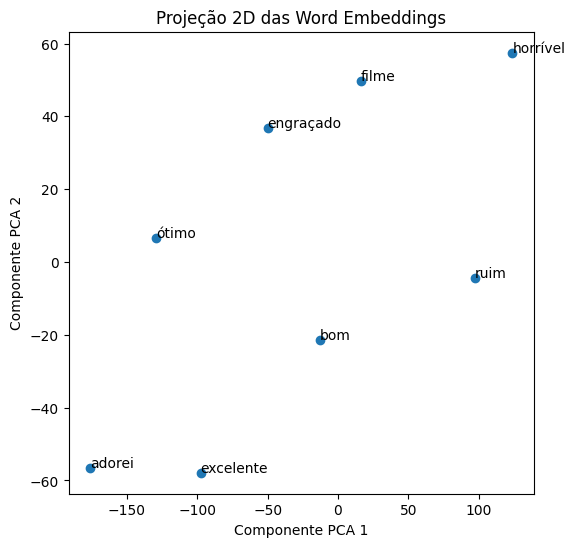

In [37]:
plt.figure(figsize=(6, 6))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])

for i, label in enumerate(labels):
    x, y = vectors_2d[i, 0], vectors_2d[i, 1]
    plt.text(x+0.01, y+0.01, label)  # um deslocamento pequeno p/ não sobrepor o ponto

plt.title("Projeção 2D das Word Embeddings")
plt.xlabel("Componente PCA 1")
plt.ylabel("Componente PCA 2")
plt.show()

Observe no gráfico se as palavras que você considera semanticamente próximas aparecem agrupadas. Se você treinou o embedding por pouco tempo ou em um dataset muito pequeno, a organização pode não ser tão clara. Em um conjunto de dados maior e após treino suficiente, é comum ver, por exemplo, palavras de conotação positiva mais próximas entre si, e as negativas agrupadas em outro canto.


## Testando outras coisas (100pt)

- Você pode tentar **ajustar hiperparâmetros** e ver o efeito: por exemplo, mudar o tamanho do vocabulário (`max_features`), a dimensão do embedding (`output_dim`), o tamanho das camadas densas, ou o número de épocas de treinamento.  
- Teste também remover **stopwords** (palavras muito comuns como "de", "o", "a", "é", que às vezes atrapalham). O `CountVectorizer` e o `Tokenizer` permitem facilmente filtrar stopwords (no CountVectorizer usamos `stop_words='portuguese'` se quisermos). Veja se isso melhora algo.  
- Experimente outras formas de combinar embeddings de palavras para representar a frase: em vez de média, poderíamos usar máxima, ou até mesmo concatenar (via Flatten) e deixar a rede tentar extrair os padrões – embora isso aumente a dimensionalidade e possivelmente a necessidade de dados.  
- Tente usar a camada Flatten ao invés de GlobalAveragePooling apos a camada de word embedding

### Carregando os dados novamente

In [4]:
# Separa colunas de texto e rótulos
texts = df['text_pt'].values
# Convert labels to numerical values (0 for 'neg', 1 for 'pos')
labels = df['sentiment'].map({'neg': 0, 'pos': 1}).values

### Parte 1 - *Bag-of-Words* + MLP (35pt)

In [5]:
unique_words = set()
for text in texts:
    t = text.split()
    unique_words.update(t)

print(len(unique_words))

348285


In [6]:
# ============================================
# PARTE 1: Bag-of-Words + MLP
# ============================================

# 1) Vetorização Bag-of-Words
max_features = 10_000
vectorizer = CountVectorizer(max_features=max_features)

X_bow = vectorizer.fit_transform(texts)

In [7]:
# 2) Dividir em treino e teste
X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    X_bow, labels, test_size=0.2, random_state=42)

print("Conjunto de treino - textos:", X_train_bow.shape, " rótulos:", y_train.shape)
print("Conjunto de teste - textos:", X_test_bow.shape, " rótulos:", y_test.shape)

Conjunto de treino - textos: (39567, 10000)  rótulos: (39567,)
Conjunto de teste - textos: (9892, 10000)  rótulos: (9892,)


In [8]:
# 3) Definir e montar o modelo MLP
model_bow = Sequential([
    InputLayer(shape=(X_train_bow.shape[1],)),
    Dense(512, activation = 'relu'),
    Dropout(0.3),
    Dense(128, activation = 'gelu'),
    Dropout(0.2),
    Dense(32, activation = 'swish'),
    Dense(1, activation = 'sigmoid')
])

model_bow.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model_bow.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │       5,120,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,190,337 (19.80 MB)

 Trainable params: 5,190,337 (19.80 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# 4) Treinar (convertemos a matriz esparsa em densa com toarray())
history_bow = model_bow.fit(X_train_bow.toarray(),
                            np.asarray([0 if x == 'neg' else 1 for x in y_train]),  # convertendo X_train de esparso para denso para treinar
                            epochs=5,
                            batch_size=32,
                            validation_data=(X_test_bow.toarray(), y_test))

Epoch 1/5
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9956 - loss: 0.0588 - val_accuracy: 0.4907 - val_loss: 9.7749
Epoch 2/5
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.4907 - val_loss: 12.0862
Epoch 3/5
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.4907 - val_loss: 13.5961
Epoch 4/5
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 1.0000 - loss: 7.9862e-04 - val_accuracy: 0.4907 - val_loss: 14.7187
Epoch 5/5
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 1.0000 - loss: 6.3492e-04 - val_accuracy: 0.4907 - val_loss: 15.6211


In [10]:
# 5) Avaliar
loss_bow, acc_bow = model_bow.evaluate(X_test_bow.toarray(), y_test, verbose=0)
print(f"Acurácia no conjunto de teste (BoW + MLP): {acc_bow:.4f}")

Acurácia no conjunto de teste (BoW + MLP): 0.4907


### Parte 2 - *Word Embeddings* + MLP (35pt)

In [12]:
# ============================================
# PARTE 2: Word Embeddings + MLP
# ============================================

# 1) Tokenizar e transformar em sequências

max_words = 10_000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

maxlen = 150
X_seq = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

In [13]:
# 2) Dividir em treino e teste
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, labels, test_size=0.2, random_state=42)

print("Treino seq shape:", X_train_seq.shape, "Teste seq shape:", X_test_seq.shape)

Treino seq shape: (39567, 150) Teste seq shape: (9892, 150)


In [39]:
# 3) Construir o modelo com camada de Embedding
embedding_dim = 150
model_emb = Sequential([
    InputLayer(shape=(X_train_seq.shape[1],)),
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              input_length=maxlen),
    GlobalAveragePooling1D(),
    Dense(64, activation = "relu"),
    Dense(8, activation = "relu"),
    Dense(1, activation = "sigmoid"),
])

model_emb.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_emb.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 150, 150)            │       1,500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 150)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │           9,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,510,193 (5.76 MB)

 Trainable params: 1,510,193 (5.76 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# 4) Treinar
history_emb = model_emb.fit(X_train_seq,
                            y_train_seq,
                            epochs=10,
                            batch_size=32,
                            validation_data=(X_test_seq, y_test_seq))

Epoch 1/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7384 - loss: 0.5071 - val_accuracy: 0.8474 - val_loss: 0.3489
Epoch 2/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8791 - loss: 0.2925 - val_accuracy: 0.8559 - val_loss: 0.3420
Epoch 3/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8976 - loss: 0.2491 - val_accuracy: 0.8223 - val_loss: 0.4258
Epoch 4/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9114 - loss: 0.2254 - val_accuracy: 0.8438 - val_loss: 0.3728
Epoch 5/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9169 - loss: 0.2095 - val_accuracy: 0.8480 - val_loss: 0.4032
Epoch 6/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9267 - loss: 0.1788 - val_accuracy: 0.8447 - val_loss: 0.4142
Epoch 7/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9357 - loss: 0.1496 - val_accuracy: 0.8376 - val_loss: 0.4792
Epoch 8/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9445 - loss: 0.1270 - 

In [41]:
# 5) Avaliar
loss_emb, acc_emb = model_emb.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"Acurácia no conjunto de teste (Embeddings + MLP): {acc_emb:.4f}")


Acurácia no conjunto de teste (Embeddings + MLP): 0.8335


### Parte 3 - Visualizando as representações criadas (30 pt)

Palavras válidas no vocabulário: ['excelente', 'incrível', 'terrível', 'excepcional', 'péssimo', 'bom', 'ruim', 'legal', 'chato']
palavras não presentes no vocabulário: {'horroroso'}


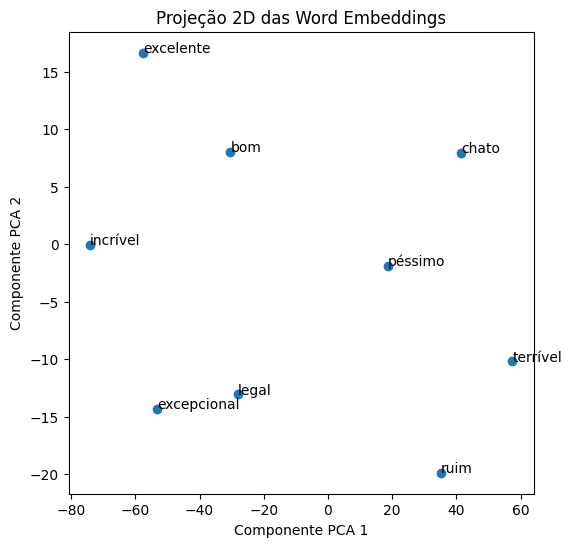

In [42]:
# ============================================
# PARTE 3: Visualização das embeddings criadas
# ============================================

# 1) Pegar os embeddings do modelo treinado
embedding_layer = model_emb.layers[0]
embedding_weights = embedding_layer.get_weights()[0]


# 2) Escolher as palavras para avaliar
# ToDo
#   - Sugestão de palavras (escolha mais)
#       - filme        - amei
#       - excelente    - ótimo
#       - bom          - horrível
#       - engraçado    - beleza
#       - estranho     - agradável
#       - avassalador  - ruim
#       - medonho      - terrível
#       - bom          - adorei

chosen_words = ["excelente", "incrível", "terrível", "horroroso", "excepcional", "péssimo", "bom", "ruim", "legal", "chato"]

# 3) Certificar de pegar somente as palavras válidas
word_index = tokenizer.word_index
valid_chosen_words = []
for w in chosen_words:
    if w in word_index and word_index[w] < embedding_weights.shape[0]:
        valid_chosen_words.append(w)
print("Palavras válidas no vocabulário:", valid_chosen_words)
print("palavras não presentes no vocabulário:", set(chosen_words) - set(valid_chosen_words))

# 4) Gerar as embeddings e os labels correspondentes para cada palavra
vectors = []
labels = []
for w in valid_chosen_words:
    idx = word_index[w]
    emb_vector = embedding_weights[idx]
    vectors.append(emb_vector)
    labels.append(w)

vectors = np.array(vectors)

# 5) Reduzir a dimensionalidade das embeddings para somente duas dimensões
tsne = TSNE(n_components=2, perplexity=5, learning_rate='auto')
vectors_2d = tsne.fit_transform(vectors)

# 6) Plotar as palavras escolhidas
plt.figure(figsize=(6, 6))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])

for i, label in enumerate(labels):
    x, y = vectors_2d[i, 0], vectors_2d[i, 1]
    plt.text(x+0.01, y+0.01, label)

plt.title("Projeção 2D das Word Embeddings")
plt.xlabel("Componente PCA 1")
plt.ylabel("Componente PCA 2")
plt.show()